# Вытаскиваем данные в dataset


**1. Импортируем библиотеки и назначаем параметры**

Маркеты: "12,976105,1,976384,136703821"

Букмекеры: 2 (Bet365)

Лиги: 82,564,384,208,72,8

Стата: "localTeam,visitorTeam,stats,odds,probability"


In [1]:
import requests
import json
import time
import pandas as pd
import os
pd.set_option('use_inf_as_na', True)
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

**Делаем запросы на данные**


In [ ]:
def make_request(endpoint, params, paginated=False):
    http = 'https://soccer.sportmonks.com/api/v2.0'
    api = http + endpoint

    payload = {
        'api_token': api_token,
        'Accept': 'application/json',
        'page': 1,
        'include': params['include'],
        'markets': params['markets'],
        'bookmakers': params['bookmakers'],
        'leagues': params['leagues']
        # 'page': 1
    }
    
    if not paginated:
        request = requests.get(api, params=payload)

        if request.status_code != 200:
            fixture_results = {
                'data': 'Error'
            }
        else:
            fixture_results = request.json()['data']
        return fixture_results
    else:
        first_request = requests.get(api, params=payload)
        reponse_meta = first_request.json()
        pages = reponse_meta['meta']['pagination']['total_pages']
        print('page length = ', pages)
        if pages == 1:
            fixture_results = reponse_meta['data']
            return fixture_results
        else:
            fixture_results = []
            for page in range(1, pages, 1):
                payload['page'] = page

                [time.sleep(2.4) if int(pages) >  1500 else None]

                request = requests.get(api, params=payload)

                fixtures = request.json()
                for fixture in fixtures['data']:
                    fixture_results.append(fixture)

            return fixture_results


api_token = 'XQGD5kyiBozfkVBvt3LVoti7rtphXVn9ukK6lJXVDQj4yhMllkDQIRX4kiiR'

# Payload - Params
params = {
    'include': "localTeam,visitorTeam,stats,odds,probability",
    'markets': "12,976105,1,976384,136703821",
    'bookmakers': "2",
    'leagues': '8,9,72,82,208,244,271,301,384,444,453,462,486,501,564,573,591,600,609'
}

paginated = True

i = 0
start_date = '2022-01-01'
end_date = '2022-01-01'
api_fixture_dateRange = '/fixtures/between/' + start_date + '/' + end_date
api_fixture = make_request(api_fixture_dateRange, params, paginated)
api_fixture

In [ ]:
# Parse raw data
year2022 = ['2022-01-01', '2022-02-01', '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01', '2022-07-01', '2022-08-01', '2022-09-01', '2022-10-01', '2022-11-01', '2022-12-01', '2023-01-01']
year2021 = ['2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01', '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01', '2021-09-01', '2021-10-01', '2021-11-01', '2021-12-01', '2021-01-01']
total_dates = year2022 + year2021
for i in range(len(total_dates)-1)[:]:
    start_date =total_dates[i]
    end_date =total_dates[i+1]
    api_fixture_dateRange = '/fixtures/between/' + start_date + '/' + end_date
    api_fixture = make_request(api_fixture_dateRange, params, paginated)
    df = pd.DataFrame.from_dict(api_fixture)
    df.to_pickle(f"rawdata2/{start_date}_{end_date}.pkl")
    print(f"Done {start_date} to {end_date}")

# Preprocess data

In [249]:
df = pd.DataFrame()
for file in os.listdir('rawdata2'):
    df_tmp = pd.read_pickle(f'rawdata2/{file}')
    # df = df_tmp.append(df)
    df = pd.concat([df_tmp, df])
df.shape

(10160, 34)

In [250]:
def extract_formations(row):
    return pd.Series({
        'h_formation': row['formations']['localteam_formation'], 
        'v_formation': row['formations']['visitorteam_formation']
        })

def extract_scores(row):
    return pd.Series({
        'h_score': row['scores']['localteam_score'], 'v_score': row['scores']['visitorteam_score'], 
        'h_score': row['scores']['localteam_score'], 'v_score': row['scores']['visitorteam_score'], 
        })

def extract_time(row):
    return pd.Series({
        'date': row['time']['starting_at']['date']
        })

def extract_standings(row):
    return pd.Series({
        'h_position': row['standings']['localteam_position'], 'v_position': row['standings']['visitorteam_position']
        })

def extract_teamName(row):
    return pd.Series({
        'h_name': row['localTeam']['data']['name'], 'v_name': row['visitorTeam']['data']['name'],
        'h_tid': row['localTeam']['data']['id'], 'v_tid': row['visitorTeam']['data']['id']
        })

def extract_stats(row):
    if len(row['stats']['data']) == 0:
        return pd.Series({}, dtype='float64')
        
    h = row['stats']['data'][0]
    v = row['stats']['data'][1]
    dic = {}
    for el in [('h', h), ('v', v)]:
        dic.update({
        f'{el[0]}_shots_total':       el[1].get('shots')['total'] if el[1].get('shots') is not None else None,
        f'{el[0]}_shots_ongoal':      el[1].get('shots')['ongoal'] if el[1].get('shots') is not None else None, 
        f'{el[0]}_shots_blocked':     el[1].get('shots')['blocked'] if el[1].get('shots') is not None else None, 
        f'{el[0]}_shots_offgoal':     el[1].get('shots')['offgoal'] if el[1].get('shots') is not None else None, 
        f'{el[0]}_shots_insidebox':   el[1].get('shots')['insidebox'] if el[1].get('shots') is not None else None, 
        f'{el[0]}_shots_outsidebox':  el[1].get('shots')['outsidebox'] if el[1].get('shots') is not None else None,
        f'{el[0]}_passes_total':      el[1].get('passes')['total'] if el[1].get('passes') is not None else None,
        f'{el[0]}_passes_accurate':   el[1].get('passes')['accurate'] if el[1].get('passes') is not None else None,
        f'{el[0]}_passes_perc':       el[1].get('passes')['percentage'] if el[1].get('passes') is not None else None, 
        f'{el[0]}_attacks_total':     el[1].get('attacks')['attacks'] if el[1].get('attacks') is not None else None, 
        f'{el[0]}_attacks_dangerous': el[1].get('attacks')['dangerous_attacks'] if el[1].get('dangerous_attacks') is not None else None, 
        f'{el[0]}_fouls':             el[1].get('fouls'), 
        f'{el[0]}_corners':           el[1].get('corners'), 
        f'{el[0]}_offsides':          el[1].get('offsides'), 
        f'{el[0]}_possessiontime':    el[1].get('possessiontime'), 
        f'{el[0]}_yellowcards':       el[1].get('yellowcards'), 
        f'{el[0]}_redcards':          el[1].get('redcards'), 
        f'{el[0]}_yellowredcards':    el[1].get('yellowredcards'), 
        f'{el[0]}_saves':             el[1].get('saves'), 
        f'{el[0]}_substitutions':     el[1].get('substitutions'), 
        f'{el[0]}_goal_kick':         el[1].get('goal_kick'), 
        f'{el[0]}_goal_attempts':     el[1].get('goal_attempts'), 
        f'{el[0]}_throw_in':          el[1].get('throw_in'), 
        f'{el[0]}_ball_safe':         el[1].get('ball_safe'), 
        f'{el[0]}_goals':             el[1].get('goals'), 
        f'{el[0]}_penalties':         el[1].get('penalties'), 
        f'{el[0]}_injuries':          el[1].get('injuries'), 
        f'{el[0]}_tackles':           el[1].get('tackles')
        })

    return pd.Series(dic)


def extract_corners_odds(row):
    try:
        bookmaker_name = row['odds']['data'][3]['bookmaker']['data'][0]['name']
        odds = row['odds']['data'][3]['bookmaker']['data'][0]['odds']['data']
        over = [i for i in odds if i['label'] == 'Over'][0]
        under = [i for i in odds if i['label'] == 'Under'][0]

        corners_over_odd  = over['value']
        total_corners_bet     = over['total']
        corners_under_odd = under['value']
        dic = pd.Series({
            'corners_over_odd': corners_over_odd, 'total_corners_bet': total_corners_bet,
            'corners_under_odd':corners_under_odd
            })
    except:
        dic = {}
    return pd.Series(dic, dtype='float64')

df = df.reset_index(drop=True)
dff = df[['id', 'league_id', 'season_id', 'stage_id', 'round_id', 'winner_team_id', ]]
dff = pd.merge(dff, df.apply(extract_formations,     axis=1).reset_index(drop=True), left_index=True, right_index=True)
dff = pd.merge(dff, df.apply(extract_scores,         axis=1).reset_index(drop=True), left_index=True, right_index=True)
dff = pd.merge(dff, df.apply(extract_time,           axis=1).reset_index(drop=True), left_index=True, right_index=True)
dff = pd.merge(dff, df.apply(extract_standings,      axis=1).reset_index(drop=True), left_index=True, right_index=True)
dff = pd.merge(dff, df.apply(extract_teamName,       axis=1).reset_index(drop=True), left_index=True, right_index=True)
dff = pd.merge(dff, df.apply(extract_stats,          axis=1).reset_index(drop=True), left_index=True, right_index=True)
dff = pd.merge(dff, df.apply(extract_corners_odds,   axis=1).reset_index(drop=True), left_index=True, right_index=True)
print(dff.shape)
dff.head()

(10160, 76)


,id,league_id,season_id,stage_id,round_id,winner_team_id,h_formation,v_formation,h_score,v_score,date,h_position,v_position,h_name,v_name,h_tid,v_tid,h_attacks_dangerous,h_attacks_total,h_ball_safe,h_corners,h_fouls,h_goal_attempts,h_goal_kick,h_goals,h_injuries,h_offsides,h_passes_accurate,h_passes_perc,h_passes_total,h_penalties,h_possessiontime,h_redcards,h_saves,h_shots_blocked,h_shots_insidebox,h_shots_offgoal,h_shots_ongoal,h_shots_outsidebox,h_shots_total,h_substitutions,h_tackles,h_throw_in,h_yellowcards,h_yellowredcards,v_attacks_dangerous,v_attacks_total,v_ball_safe,v_corners,v_fouls,v_goal_attempts,v_goal_kick,v_goals,v_injuries,v_offsides,v_passes_accurate,v_passes_perc,v_passes_total,v_penalties,v_possessiontime,v_redcards,v_saves,v_shots_blocked,v_shots_insidebox,v_shots_offgoal,v_shots_ongoal,v_shots_outsidebox,v_shots_total,v_substitutions,v_tackles,v_throw_in,v_yellowcards,v_yellowredcards,corners_over_odd,corners_under_odd,total_corners_bet
0,18468160,444,19369,77456618,266963.0,2601.0,4-2-3-1,4-3-3,5,1,2022-06-18,7.0,4.0,Sarpsborg 08,Strømsgodset,2601,313,NaN,111.0,113.0,9.0,16.0,13.0,NaN,5.0,2.0,1.0,413.0,84.46,489.0,2.0,60.0,0.0,5.0,1.0,12.0,10.0,7.0,6.0,17.0,3.0,15.0,NaN,2.0,0.0,NaN,71.0,85.0,3.0,14.0,11.0,NaN,1.0,1.0,0.0,265.0,82.30,322.0,0.0,40.0,0.0,3.0,0.0,13.0,8.0,6.0,2.0,14.0,4.0,12.0,NaN,1.0,0.0,2.10,2.10,11.0
1,18468161,444,19369,77456618,266963.0,1668.0,4-2-3-1,4-3-3,0,2,2022-06-18,16.0,8.0,Kristiansund,Bodø / Glimt,869,1668,NaN,59.0,64.0,4.0,10.0,7.0,NaN,0.0,1.0,3.0,191.0,69.45,275.0,0.0,33.0,0.0,7.0,1.0,5.0,4.0,4.0,3.0,8.0,6.0,17.0,NaN,2.0,0.0,NaN,119.0,68.0,9.0,10.0,15.0,NaN,2.0,0.0,0.0,467.0,83.24,561.0,0.0,67.0,0.0,4.0,3.0,19.0,20.0,2.0,4.0,22.0,4.0,17.0,NaN,1.0,0.0,2.38,1.83,12.0
2,18468162,444,19369,77456618,266963.0,8661.0,3-4-3,5-3-2,1,2,2022-06-19,15.0,12.0,Jerv,HamKam,2469,8661,NaN,116.0,107.0,10.0,18.0,13.0,NaN,1.0,NaN,3.0,401.0,79.56,504.0,0.0,63.0,0.0,3.0,5.0,9.0,10.0,8.0,9.0,18.0,3.0,11.0,NaN,0.0,0.0,NaN,95.0,99.0,4.0,13.0,11.0,NaN,2.0,NaN,1.0,195.0,66.10,295.0,0.0,37.0,0.0,6.0,3.0,9.0,10.0,5.0,7.0,15.0,2.0,12.0,NaN,1.0,0.0,2.20,2.00,11.0
3,18468163,444,19369,77456618,266963.0,2510.0,3-4-3,3-4-1-2,3,1,2022-06-19,1.0,8.0,Lillestrøm,Rosenborg,2510,1335,NaN,116.0,88.0,6.0,14.0,9.0,NaN,3.0,NaN,2.0,342.0,79.17,432.0,0.0,51.0,0.0,4.0,1.0,9.0,9.0,3.0,4.0,12.0,4.0,15.0,NaN,1.0,0.0,NaN,110.0,82.0,1.0,13.0,8.0,NaN,1.0,NaN,1.0,349.0,81.54,428.0,0.0,49.0,0.0,1.0,1.0,6.0,7.0,1.0,2.0,8.0,5.0,12.0,NaN,2.0,0.0,2.20,2.00,12.0
4,18468164,444,19369,77456618,266963.0,290.0,4-3-3,3-5-2,1,2,2022-06-19,9.0,2.0,Odd,Molde,930,290,NaN,128.0,84.0,3.0,0.0,9.0,NaN,1.0,NaN,0.0,436.0,83.37,523.0,0.0,53.0,0.0,2.0,4.0,10.0,7.0,9.0,8.0,16.0,3.0,9.0,NaN,1.0,0.0,NaN,88.0,96.0,3.0,1.0,11.0,NaN,2.0,NaN,0.0,366.0,79.22,462.0,0.0,47.0,0.0,6.0,2.0,14.0,13.0,4.0,3.0,17.0,3.0,8.0,NaN,3.0,0.0,1.91,2.25,10.0


In [251]:

# dff['h_score_pos'] = dff['h_score']
# dff['v_score_pos'] = dff['v_score']

# targets = ['total_corners', 'h_score_pos', 'v_score_pos', 'h_corners', 'v_corners', 'h_score', 'v_score']
# util_cols = ['date', 'h_name', 'v_name', 'id', 'league_id', 'season_id', 'stage_id', 'round_id', 'winner_team_id', 'h_tid', 'v_tid']
# feature_cols = [
#     'h_formation', 'v_formation', 'h_position', 'v_position',  'h_attacks_dangerous', 'h_attacks_total', 'h_ball_safe', 
#     'h_fouls', 'h_goal_attempts', 'h_goal_kick', 'h_goals', 'h_injuries', 'h_offsides', 'h_passes_accurate', 
#     'h_passes_perc', 'h_passes_total', 'h_penalties', 'h_possessiontime', 'h_redcards', 'h_saves', 
#     'h_shots_blocked', 'h_shots_insidebox', 'h_shots_offgoal', 'h_shots_ongoal', 'h_shots_outsidebox', 'h_shots_total', 
#     'h_substitutions', 'h_tackles', 'h_throw_in', 'h_yellowcards', 'h_yellowredcards', 
    
#     'v_attacks_dangerous', 'v_attacks_total', 'v_ball_safe', 'v_fouls', 'v_goal_attempts', 'v_goal_kick', 'v_goals', 'v_injuries', 
#     'v_offsides', 'v_passes_accurate', 'v_passes_perc', 'v_passes_total', 'v_penalties', 'v_possessiontime', 'v_redcards', 'v_saves', 
#     'v_shots_blocked', 'v_shots_insidebox', 'v_shots_offgoal', 'v_shots_ongoal', 'v_shots_outsidebox', 'v_shots_total', 'v_substitutions', 
#     'v_tackles', 'v_throw_in', 'v_yellowcards', 'v_yellowredcards']

# dff = dff[targets+util_cols+feature_cols]
# dff.shape

In [252]:
from tqdm.auto import tqdm

# targets = ['total_corners', 'h_score_pos', 'v_score_pos', 'h_corners', 'v_corners', 'h_score', 'v_score']
util_cols = [
    'date', 'id', 'league_id', 'season_id', 'stage_id', 'round_id', 'winner_team_id',
    'corners_over_odd', 'corners_under_odd', 'total_corners_bet', 'total_corners'
    ]

base_feature_cols = ['tid', 'name', 'corners', 'score',
    'formation', 'position', 'attacks_dangerous', 'attacks_total', 'ball_safe', 
    'fouls', 'goal_attempts', 'goal_kick', 'goals', 'injuries', 'offsides', 'passes_accurate', 
    'passes_perc', 'passes_total', 'penalties', 'possessiontime', 'redcards', 'saves', 
    'shots_blocked', 'shots_insidebox', 'shots_offgoal', 'shots_ongoal', 'shots_outsidebox', 'shots_total', 
    'substitutions', 'tackles', 'throw_in', 'yellowcards', 'yellowredcards']

both_teams_base_feature_cols = [f'h_{col}' for col in base_feature_cols] + [f'v_{col}' for col in base_feature_cols]

ldf = pd.DataFrame()
dff['total_corners'] = dff['h_corners'] + dff['v_corners']

unique_tids = list(set(dff['h_tid'].tolist()+dff['v_tid'].tolist()))
for tid in tqdm(unique_tids):
    h = dff[dff['h_tid'] == tid][util_cols+both_teams_base_feature_cols]
    h = h.rename(columns={col: col.replace('h_', 'f_') for col in h.columns})
    h = h.rename(columns={col: col.replace('v_', 's_') for col in h.columns})

    v = dff[dff['v_tid'] == tid][util_cols+both_teams_base_feature_cols]
    v = v.rename(columns={col: col.replace('v_', 'f_') for col in v.columns})
    v = v.rename(columns={col: col.replace('h_', 's_') for col in v.columns})

    ldf = pd.concat([ldf, h, v])
    
print(ldf.shape)
ldf = ldf.drop_duplicates()
print(ldf.shape)
ldf = ldf.reset_index(drop=True).sort_values(['date', 'f_tid', 's_tid'])

  0%|          | 0/389 [00:00<?, ?it/s]

(20320, 77)
(20196, 77)


<AxesSubplot: >

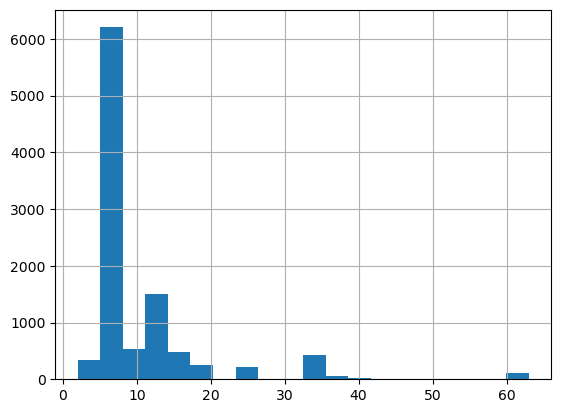

In [253]:
dff.isna().sum(axis=1).hist(bins=20)

In [254]:
# оставим строчки где меньше 10 нанов
dff = dff[dff.isna().sum(axis=1)<10]

In [255]:
ldf[(ldf['f_name']=='West Ham United') & (ldf['date']=='2022-10-01')]

,date,id,league_id,season_id,stage_id,round_id,winner_team_id,corners_over_odd,corners_under_odd,total_corners_bet,total_corners,f_tid,f_name,f_corners,f_score,f_formation,f_position,f_attacks_dangerous,f_attacks_total,f_ball_safe,f_fouls,f_goal_attempts,f_goal_kick,f_goals,f_injuries,f_offsides,f_passes_accurate,f_passes_perc,f_passes_total,f_penalties,f_possessiontime,f_redcards,f_saves,f_shots_blocked,f_shots_insidebox,f_shots_offgoal,f_shots_ongoal,f_shots_outsidebox,f_shots_total,f_substitutions,f_tackles,f_throw_in,f_yellowcards,f_yellowredcards,s_tid,s_name,s_corners,s_score,s_formation,s_position,s_attacks_dangerous,s_attacks_total,s_ball_safe,s_fouls,s_goal_attempts,s_goal_kick,s_goals,s_injuries,s_offsides,s_passes_accurate,s_passes_perc,s_passes_total,s_penalties,s_possessiontime,s_redcards,s_saves,s_shots_blocked,s_shots_insidebox,s_shots_offgoal,s_shots_ongoal,s_shots_outsidebox,s_shots_total,s_substitutions,s_tackles,s_throw_in,s_yellowcards,s_yellowredcards
29,2022-10-01,18535100,8,19734,77457864,274676.0,1.0,2.1,2.1,10.0,7.0,1,West Ham United,1.0,2,4-2-3-1,18.0,NaN,88.0,57.0,9.0,5.0,15.0,2.0,2.0,2.0,296.0,80.43,368.0,0.0,40.0,0.0,4.0,3.0,11.0,13.0,5.0,8.0,18.0,3.0,23.0,11.0,2.0,0.0,29,Wolverhampton Wanderers,6.0,0,3-4-2-1,17.0,NaN,127.0,64.0,6.0,7.0,6.0,0.0,2.0,1.0,478.0,86.91,550.0,0.0,60.0,0.0,3.0,3.0,7.0,11.0,4.0,8.0,15.0,4.0,12.0,22.0,2.0,0.0


In [256]:
ldf[(ldf['s_name']=='West Ham United') & (ldf['date']=='2022-10-01')]


,date,id,league_id,season_id,stage_id,round_id,winner_team_id,corners_over_odd,corners_under_odd,total_corners_bet,total_corners,f_tid,f_name,f_corners,f_score,f_formation,f_position,f_attacks_dangerous,f_attacks_total,f_ball_safe,f_fouls,f_goal_attempts,f_goal_kick,f_goals,f_injuries,f_offsides,f_passes_accurate,f_passes_perc,f_passes_total,f_penalties,f_possessiontime,f_redcards,f_saves,f_shots_blocked,f_shots_insidebox,f_shots_offgoal,f_shots_ongoal,f_shots_outsidebox,f_shots_total,f_substitutions,f_tackles,f_throw_in,f_yellowcards,f_yellowredcards,s_tid,s_name,s_corners,s_score,s_formation,s_position,s_attacks_dangerous,s_attacks_total,s_ball_safe,s_fouls,s_goal_attempts,s_goal_kick,s_goals,s_injuries,s_offsides,s_passes_accurate,s_passes_perc,s_passes_total,s_penalties,s_possessiontime,s_redcards,s_saves,s_shots_blocked,s_shots_insidebox,s_shots_offgoal,s_shots_ongoal,s_shots_outsidebox,s_shots_total,s_substitutions,s_tackles,s_throw_in,s_yellowcards,s_yellowredcards
1837,2022-10-01,18535100,8,19734,77457864,274676.0,1.0,2.1,2.1,10.0,7.0,29,Wolverhampton Wanderers,6.0,0,3-4-2-1,17.0,NaN,127.0,64.0,6.0,7.0,6.0,0.0,2.0,1.0,478.0,86.91,550.0,0.0,60.0,0.0,3.0,3.0,7.0,11.0,4.0,8.0,15.0,4.0,12.0,22.0,2.0,0.0,1,West Ham United,1.0,2,4-2-3-1,18.0,NaN,88.0,57.0,9.0,5.0,15.0,2.0,2.0,2.0,296.0,80.43,368.0,0.0,40.0,0.0,4.0,3.0,11.0,13.0,5.0,8.0,18.0,3.0,23.0,11.0,2.0,0.0


In [257]:
ldf[ldf['id']==18535100]

,date,id,league_id,season_id,stage_id,round_id,winner_team_id,corners_over_odd,corners_under_odd,total_corners_bet,total_corners,f_tid,f_name,f_corners,f_score,f_formation,f_position,f_attacks_dangerous,f_attacks_total,f_ball_safe,f_fouls,f_goal_attempts,f_goal_kick,f_goals,f_injuries,f_offsides,f_passes_accurate,f_passes_perc,f_passes_total,f_penalties,f_possessiontime,f_redcards,f_saves,f_shots_blocked,f_shots_insidebox,f_shots_offgoal,f_shots_ongoal,f_shots_outsidebox,f_shots_total,f_substitutions,f_tackles,f_throw_in,f_yellowcards,f_yellowredcards,s_tid,s_name,s_corners,s_score,s_formation,s_position,s_attacks_dangerous,s_attacks_total,s_ball_safe,s_fouls,s_goal_attempts,s_goal_kick,s_goals,s_injuries,s_offsides,s_passes_accurate,s_passes_perc,s_passes_total,s_penalties,s_possessiontime,s_redcards,s_saves,s_shots_blocked,s_shots_insidebox,s_shots_offgoal,s_shots_ongoal,s_shots_outsidebox,s_shots_total,s_substitutions,s_tackles,s_throw_in,s_yellowcards,s_yellowredcards
29,2022-10-01,18535100,8,19734,77457864,274676.0,1.0,2.1,2.1,10.0,7.0,1,West Ham United,1.0,2,4-2-3-1,18.0,NaN,88.0,57.0,9.0,5.0,15.0,2.0,2.0,2.0,296.0,80.43,368.0,0.0,40.0,0.0,4.0,3.0,11.0,13.0,5.0,8.0,18.0,3.0,23.0,11.0,2.0,0.0,29,Wolverhampton Wanderers,6.0,0,3-4-2-1,17.0,NaN,127.0,64.0,6.0,7.0,6.0,0.0,2.0,1.0,478.0,86.91,550.0,0.0,60.0,0.0,3.0,3.0,7.0,11.0,4.0,8.0,15.0,4.0,12.0,22.0,2.0,0.0
1837,2022-10-01,18535100,8,19734,77457864,274676.0,1.0,2.1,2.1,10.0,7.0,29,Wolverhampton Wanderers,6.0,0,3-4-2-1,17.0,NaN,127.0,64.0,6.0,7.0,6.0,0.0,2.0,1.0,478.0,86.91,550.0,0.0,60.0,0.0,3.0,3.0,7.0,11.0,4.0,8.0,15.0,4.0,12.0,22.0,2.0,0.0,1,West Ham United,1.0,2,4-2-3-1,18.0,NaN,88.0,57.0,9.0,5.0,15.0,2.0,2.0,2.0,296.0,80.43,368.0,0.0,40.0,0.0,4.0,3.0,11.0,13.0,5.0,8.0,18.0,3.0,23.0,11.0,2.0,0.0


In [258]:
ldf['id'].value_counts().unique()

array([2])

In [259]:
def calc_rolling(ldf, team_pos, rolling_cols, rolling_window):
    grouped = ldf.groupby(f'{team_pos}_tid')

    pos_rolling_cols = [f'{team_pos}_{col}' for col in rolling_cols]
    
    # Calculate rolling mean for the last 3 rows for each group
    rolling_mean = grouped[pos_rolling_cols].apply(lambda x: x.rolling(rolling_window, 1).mean().shift())
    rolling_mean = rolling_mean.rename(columns={col: col.replace(f'{team_pos}_', f'{team_pos}_rol_{rolling_window}_mean_', 2) for col in rolling_mean.columns})#.reset_index()
    rolling_mean_cols = rolling_mean.columns.tolist()

    # min
    rolling_min = grouped[pos_rolling_cols].apply(lambda x: x.rolling(rolling_window, 1).min().shift())
    rolling_min  = rolling_min.rename(columns={col: col.replace(f'{team_pos}_', f'{team_pos}_rol_{rolling_window}_min_', 2) for col in rolling_min.columns})#.reset_index()
    rolling_min_cols = rolling_min.columns.tolist()

    # max
    rolling_max = grouped[pos_rolling_cols].apply(lambda x: x.rolling(rolling_window, 1).max().shift())
    rolling_max  = rolling_max.rename(columns={col: col.replace(f'{team_pos}_', f'{team_pos}_rol_{rolling_window}_max_', 2) for col in rolling_max.columns})#.reset_index()
    rolling_max_cols = rolling_max.columns.tolist()

    ldf = ldf.merge(rolling_mean, left_index=True, right_index=True)
    ldf = ldf.merge(rolling_min, left_index=True, right_index=True)
    ldf = ldf.merge(rolling_max, left_index=True, right_index=True)

    return ldf, rolling_mean_cols+rolling_min_cols+rolling_max_cols

rolling_cols = ['corners', 'score',
    'position', 'attacks_dangerous', 'attacks_total', 'ball_safe', 
    'fouls', 'goal_attempts', 'goal_kick', 'goals', 'injuries', 'offsides', 'passes_accurate', 
    'passes_perc', 'passes_total', 'penalties', 'possessiontime', 'redcards', 'saves', 
    'shots_blocked', 'shots_insidebox', 'shots_offgoal', 'shots_ongoal', 'shots_outsidebox', 'shots_total', 
    'substitutions', 'tackles', 'throw_in', 'yellowcards', 'yellowredcards']

ldf = ldf.reset_index()
ldf2 = ldf.copy()
ldf_f_rolling, f_rolling_cols_3 = calc_rolling(ldf=ldf2, team_pos='f', rolling_cols=rolling_cols, rolling_window=3)
ldf_s_rolling, s_rolling_cols_3 = calc_rolling(ldf=ldf2, team_pos='s', rolling_cols=rolling_cols, rolling_window=3)

ldf2 = ldf2.merge(ldf_f_rolling, left_index=True, right_index=True)
ldf2 = ldf2.merge(ldf_s_rolling, left_index=True, right_index=True)


In [260]:
ldf2['match_num'] = ldf2.groupby('s_tid').cumcount(1)
q = ldf2[ldf2['s_tid'].isin([13])].sort_values(['s_tid', 'date'])
q[['date', 's_tid', 's_rol_3_mean_corners', 's_rol_3_max_corners', 's_rol_3_min_corners', 's_corners', 'match_num']][:10]

,date,s_tid,s_rol_3_mean_corners,s_rol_3_max_corners,s_rol_3_min_corners,s_corners,match_num
0,2021-01-01,13,NaN,NaN,NaN,5.0,0
371,2021-01-12,13,5.000000,5.0,5.0,5.0,1
924,2021-01-27,13,5.000000,5.0,5.0,5.0,2
1012,2021-01-30,13,5.000000,5.0,5.0,7.0,3
1264,2021-02-03,13,5.666667,7.0,5.0,1.0,4
1372,2021-02-06,13,4.333333,7.0,1.0,1.0,5
1737,2021-02-14,13,3.000000,7.0,1.0,5.0,6
1881,2021-02-17,13,2.333333,5.0,1.0,0.0,7
1948,2021-02-20,13,2.000000,5.0,0.0,2.0,8
2401,2021-03-01,13,2.333333,5.0,0.0,4.0,9


In [261]:
train_cols = f_rolling_cols_3 + s_rolling_cols_3
train_cols = [col for col in train_cols if col not in ['f_tid', 's_tid', 'level_1']]
# train_cols += ['h_formation', 'v_formation']

In [262]:
total_matches = ldf2['id'].unique().shape[0]
train_matches_ids = ldf2['id'].unique().tolist()[:int(total_matches*0.8)]
test_matches_ids = ldf2['id'].unique().tolist()[int(total_matches*0.8):]

In [295]:
target = 'total_corners_10+'
ldf2[target] = (ldf2['total_corners']>10).astype(int)
train = ldf2[(ldf2['id'].isin(train_matches_ids)) & (ldf2['match_num']>=3)]
test = ldf2[ldf2['id'].isin(test_matches_ids) & (ldf2['match_num']>=3)]
train.shape, test.shape

((15015, 416), (4014, 416))

In [296]:
test[['total_corners', target]].describe()

,total_corners,total_corners_10+
count,3980.000000,4014.000000
mean,9.932915,0.399601
std,3.451276,0.489877
min,0.000000,0.000000
25%,7.000000,0.000000
50%,10.000000,0.000000
75%,12.000000,1.000000
max,24.000000,1.000000


In [297]:
X_train, y_train = train[train_cols], train[target]
X_test, y_test = test[train_cols], test[target]

In [298]:
from catboost import CatBoostClassifier
import catboost 
from catboost import Pool

clf = CatBoostClassifier(iterations=1000, 
                           depth=5,
                           learning_rate=0.01,
                           grow_policy='SymmetricTree', #SymmetricTree Depthwise
                           border_count=254,
                           colsample_bylevel=0.4,
                           subsample=0.8,
                           eval_metric='Accuracy',
                           boosting_type='Plain', # 'Plain'
                           bootstrap_type='Bernoulli',
                           has_time=True,
                           task_type='CPU',
                        #    cat_features=['h_formation', 'v_formation'],
                           use_best_model=True,
                          )

clf.fit(X_train, y_train, plot=True, eval_set=(X_test, y_test), verbose=False)
clf.get_feature_importance(prettified=True)#[:50]['Feature Id'].values

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

,Feature Id,Importances
0,f_rol_3_max_attacks_total,2.170525
1,s_rol_3_mean_redcards,2.105282
2,s_rol_3_mean_corners,1.868222
3,f_rol_3_min_corners,1.672949
4,f_rol_3_max_corners,1.644093
...,...,...
175,f_rol_3_min_attacks_dangerous,0.000000
176,f_rol_3_max_attacks_dangerous,0.000000
177,s_rol_3_mean_attacks_rol_3_mean_dangerous,0.000000
178,s_rol_3_min_attacks_rol_3_min_dangerous,0.000000


In [299]:
fimp = clf.get_feature_importance(prettified=True)
best_features = fimp[:20]
top_features = best_features['Feature Id']
top_features

0                  f_rol_3_max_attacks_total
1                      s_rol_3_mean_redcards
2                       s_rol_3_mean_corners
3                        f_rol_3_min_corners
4                        f_rol_3_max_corners
5                         s_rol_3_mean_saves
6                       f_rol_3_mean_corners
7                s_rol_3_mean_possessiontime
8          s_rol_3_max_shots_rol_3_max_total
9                   s_rol_3_mean_yellowcards
10                      s_rol_3_max_redcards
11                       s_rol_3_max_corners
12                      s_rol_3_min_redcards
13    s_rol_3_max_shots_rol_3_max_outsidebox
14                s_rol_3_max_possessiontime
15                    s_rol_3_mean_penalties
16                   f_rol_3_max_shots_total
17                       s_rol_3_min_corners
18                s_rol_3_mean_substitutions
19                    f_rol_3_mean_penalties
Name: Feature Id, dtype: object

In [300]:
from catboost import CatBoostClassifier
import catboost 
from catboost import Pool

clf = CatBoostClassifier(iterations=1000, 
                           depth=5,
                           learning_rate=0.01,
                           grow_policy='SymmetricTree', #SymmetricTree Depthwise
                           border_count=254,
                           colsample_bylevel=0.4,
                           subsample=0.8,
                           eval_metric='Accuracy',
                           boosting_type='Plain', # 'Plain'
                           bootstrap_type='Bernoulli',
                           has_time=True,
                           task_type='CPU',
                        #    cat_features=['h_formation', 'v_formation'],
                           use_best_model=True,
                          )

clf.fit(X_train[top_features], y_train, plot=True, eval_set=(X_test[top_features], y_test), verbose=False)
clf.get_feature_importance(prettified=True)#[:50]['Feature Id'].values

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

,Feature Id,Importances
0,s_rol_3_min_redcards,9.095825
1,s_rol_3_max_redcards,7.369963
2,s_rol_3_max_corners,6.938726
3,f_rol_3_max_attacks_total,6.432471
4,s_rol_3_mean_saves,6.288168
5,s_rol_3_mean_possessiontime,6.181094
6,s_rol_3_mean_corners,5.838237
7,s_rol_3_max_shots_rol_3_max_total,5.282514
8,s_rol_3_max_possessiontime,4.900143
9,s_rol_3_min_corners,4.608132


In [301]:
from sklearn.metrics import accuracy_score
test = test.copy()
test.loc[test.index, 'y_proba'] = clf.predict_proba(test[clf.feature_names_])[:,1]
test.loc[test.index, 'y_pred'] = clf.predict(test[clf.feature_names_])
print(test['y_pred'].mean())
(test['y_pred']==test[target]).mean()


0.006726457399103139


0.6031390134529148

In [302]:
test[target].mean()

0.3996013951170902

In [303]:
# Усреднить предикты по каждому матчу
test_1half = test.drop_duplicates(subset='id').copy()
test_2half = test.loc[~test.index.isin(test_1half.index)].copy()
test_1half['y_proba2'] = test_1half['y_proba']

test_comb = pd.merge(test_2half[['id', 'y_proba', target]], test_1half[['id', 'y_proba2']], on='id', how='left')

test_comb['y_proba_comb'] = (test_comb['y_proba2']+test_comb['y_proba'])/2
test_comb['y_pred2'] = (test_comb['y_proba_comb']>=0.5).astype(int)
print(test_comb['y_pred2'].mean())
(test_comb['y_pred2']==test_comb[target]).mean()

0.003510531594784353


0.6023069207622869

In [304]:
test_1half[test_1half['id']==18546238]

,index_x,date_x,id_x,league_id_x,season_id_x,stage_id_x,round_id_x,winner_team_id_x,corners_over_odd_x,corners_under_odd_x,total_corners_bet_x,total_corners_x,f_tid_x,f_name_x,f_corners_x,f_score_x,f_formation_x,f_position_x,f_attacks_dangerous_x,f_attacks_total_x,f_ball_safe_x,f_fouls_x,f_goal_attempts_x,f_goal_kick_x,f_goals_x,f_injuries_x,f_offsides_x,f_passes_accurate_x,f_passes_perc_x,f_passes_total_x,f_penalties_x,f_possessiontime_x,f_redcards_x,f_saves_x,f_shots_blocked_x,f_shots_insidebox_x,f_shots_offgoal_x,f_shots_ongoal_x,f_shots_outsidebox_x,f_shots_total_x,f_substitutions_x,f_tackles_x,f_throw_in_x,f_yellowcards_x,f_yellowredcards_x,s_tid_x,s_name_x,s_corners_x,s_score_x,s_formation_x,s_position_x,s_attacks_dangerous_x,s_attacks_total_x,s_ball_safe_x,s_fouls_x,s_goal_attempts_x,s_goal_kick_x,s_goals_x,s_injuries_x,s_offsides_x,s_passes_accurate_x,s_passes_perc_x,s_passes_total_x,s_penalties_x,s_possessiontime_x,s_redcards_x,s_saves_x,s_shots_blocked_x,s_shots_insidebox_x,s_shots_offgoal_x,s_shots_ongoal_x,s_shots_outsidebox_x,s_shots_total_x,s_substitutions_x,s_tackles_x,s_throw_in_x,s_yellowcards_x,s_yellowredcards_x,index_y,date_y,id_y,league_id_y,season_id_y,stage_id_y,round_id_y,winner_team_id_y,corners_over_odd_y,corners_under_odd_y,total_corners_bet_y,total_corners_y,f_tid_y,f_name_y,f_corners_y,f_score_y,f_formation_y,f_position_y,f_attacks_dangerous_y,f_attacks_total_y,f_ball_safe_y,f_fouls_y,f_goal_attempts_y,f_goal_kick_y,f_goals_y,f_injuries_y,f_offsides_y,f_passes_accurate_y,f_passes_perc_y,f_passes_total_y,f_penalties_y,f_possessiontime_y,f_redcards_y,f_saves_y,f_shots_blocked_y,f_shots_insidebox_y,f_shots_offgoal_y,f_shots_ongoal_y,f_shots_outsidebox_y,f_shots_total_y,f_substitutions_y,f_tackles_y,f_throw_in_y,f_yellowcards_y,f_yellowredcards_y,s_tid_y,s_name_y,s_corners_y,s_score_y,s_formation_y,s_position_y,s_attacks_dangerous_y,s_attacks_total_y,s_ball_safe_y,s_fouls_y,s_goal_attempts_y,s_goal_kick_y,s_goals_y,s_injuries_y,s_offsides_y,s_passes_accurate_y,s_passes_perc_y,s_passes_total_y,s_penalties_y,s_possessiontime_y,s_redcards_y,s_saves_y,s_shots_blocked_y,s_shots_insidebox_y,s_shots_offgoal_y,s_shots_ongoal_y,s_shots_outsidebox_y,s_shots_total_y,s_substitutions_y,s_tackles_y,s_throw_in_y,s_yellowcards_y,s_yellowredcards_y,f_rol_3_mean_corners,f_rol_3_mean_score,f_rol_3_mean_position,f_rol_3_mean_attacks_dangerous,f_rol_3_mean_attacks_total,f_rol_3_mean_ball_safe,f_rol_3_mean_fouls,f_rol_3_mean_goal_attempts,f_rol_3_mean_goal_kick,f_rol_3_mean_goals,f_rol_3_mean_injuries,f_rol_3_mean_offsides,f_rol_3_mean_passes_accurate,f_rol_3_mean_passes_perc,f_rol_3_mean_passes_total,f_rol_3_mean_penalties,f_rol_3_mean_possessiontime,f_rol_3_mean_redcards,f_rol_3_mean_saves,f_rol_3_mean_shots_blocked,f_rol_3_mean_shots_insidebox,f_rol_3_mean_shots_offgoal,f_rol_3_mean_shots_ongoal,f_rol_3_mean_shots_outsidebox,f_rol_3_mean_shots_total,f_rol_3_mean_substitutions,f_rol_3_mean_tackles,f_rol_3_mean_throw_in,f_rol_3_mean_yellowcards,f_rol_3_mean_yellowredcards,f_rol_3_min_corners,f_rol_3_min_score,f_rol_3_min_position,f_rol_3_min_attacks_dangerous,f_rol_3_min_attacks_total,f_rol_3_min_ball_safe,f_rol_3_min_fouls,f_rol_3_min_goal_attempts,f_rol_3_min_goal_kick,f_rol_3_min_goals,f_rol_3_min_injuries,f_rol_3_min_offsides,f_rol_3_min_passes_accurate,f_rol_3_min_passes_perc,f_rol_3_min_passes_total,f_rol_3_min_penalties,f_rol_3_min_possessiontime,f_rol_3_min_redcards,f_rol_3_min_saves,f_rol_3_min_shots_blocked,f_rol_3_min_shots_insidebox,f_rol_3_min_shots_offgoal,f_rol_3_min_shots_ongoal,f_rol_3_min_shots_outsidebox,f_rol_3_min_shots_total,f_rol_3_min_substitutions,f_rol_3_min_tackles,f_rol_3_min_throw_in,f_rol_3_min_yellowcards,f_rol_3_min_yellowredcards,f_rol_3_max_corners,f_rol_3_max_score,f_rol_3_max_position,f_rol_3_max_attacks_dangerous,f_rol_3_max_attacks_total,f_rol_3_max_ball_safe,f_rol_3_max_fouls,f_rol_3_max_goal_attempts,f_rol_3_max_goal_kick,f_rol_3_max_goals,f_rol_3_max_injuries,f_rol_3_max_offsides,f_

In [305]:
test_2half[test_2half['id']==18546238]

,index_x,date_x,id_x,league_id_x,season_id_x,stage_id_x,round_id_x,winner_team_id_x,corners_over_odd_x,corners_under_odd_x,total_corners_bet_x,total_corners_x,f_tid_x,f_name_x,f_corners_x,f_score_x,f_formation_x,f_position_x,f_attacks_dangerous_x,f_attacks_total_x,f_ball_safe_x,f_fouls_x,f_goal_attempts_x,f_goal_kick_x,f_goals_x,f_injuries_x,f_offsides_x,f_passes_accurate_x,f_passes_perc_x,f_passes_total_x,f_penalties_x,f_possessiontime_x,f_redcards_x,f_saves_x,f_shots_blocked_x,f_shots_insidebox_x,f_shots_offgoal_x,f_shots_ongoal_x,f_shots_outsidebox_x,f_shots_total_x,f_substitutions_x,f_tackles_x,f_throw_in_x,f_yellowcards_x,f_yellowredcards_x,s_tid_x,s_name_x,s_corners_x,s_score_x,s_formation_x,s_position_x,s_attacks_dangerous_x,s_attacks_total_x,s_ball_safe_x,s_fouls_x,s_goal_attempts_x,s_goal_kick_x,s_goals_x,s_injuries_x,s_offsides_x,s_passes_accurate_x,s_passes_perc_x,s_passes_total_x,s_penalties_x,s_possessiontime_x,s_redcards_x,s_saves_x,s_shots_blocked_x,s_shots_insidebox_x,s_shots_offgoal_x,s_shots_ongoal_x,s_shots_outsidebox_x,s_shots_total_x,s_substitutions_x,s_tackles_x,s_throw_in_x,s_yellowcards_x,s_yellowredcards_x,index_y,date_y,id_y,league_id_y,season_id_y,stage_id_y,round_id_y,winner_team_id_y,corners_over_odd_y,corners_under_odd_y,total_corners_bet_y,total_corners_y,f_tid_y,f_name_y,f_corners_y,f_score_y,f_formation_y,f_position_y,f_attacks_dangerous_y,f_attacks_total_y,f_ball_safe_y,f_fouls_y,f_goal_attempts_y,f_goal_kick_y,f_goals_y,f_injuries_y,f_offsides_y,f_passes_accurate_y,f_passes_perc_y,f_passes_total_y,f_penalties_y,f_possessiontime_y,f_redcards_y,f_saves_y,f_shots_blocked_y,f_shots_insidebox_y,f_shots_offgoal_y,f_shots_ongoal_y,f_shots_outsidebox_y,f_shots_total_y,f_substitutions_y,f_tackles_y,f_throw_in_y,f_yellowcards_y,f_yellowredcards_y,s_tid_y,s_name_y,s_corners_y,s_score_y,s_formation_y,s_position_y,s_attacks_dangerous_y,s_attacks_total_y,s_ball_safe_y,s_fouls_y,s_goal_attempts_y,s_goal_kick_y,s_goals_y,s_injuries_y,s_offsides_y,s_passes_accurate_y,s_passes_perc_y,s_passes_total_y,s_penalties_y,s_possessiontime_y,s_redcards_y,s_saves_y,s_shots_blocked_y,s_shots_insidebox_y,s_shots_offgoal_y,s_shots_ongoal_y,s_shots_outsidebox_y,s_shots_total_y,s_substitutions_y,s_tackles_y,s_throw_in_y,s_yellowcards_y,s_yellowredcards_y,f_rol_3_mean_corners,f_rol_3_mean_score,f_rol_3_mean_position,f_rol_3_mean_attacks_dangerous,f_rol_3_mean_attacks_total,f_rol_3_mean_ball_safe,f_rol_3_mean_fouls,f_rol_3_mean_goal_attempts,f_rol_3_mean_goal_kick,f_rol_3_mean_goals,f_rol_3_mean_injuries,f_rol_3_mean_offsides,f_rol_3_mean_passes_accurate,f_rol_3_mean_passes_perc,f_rol_3_mean_passes_total,f_rol_3_mean_penalties,f_rol_3_mean_possessiontime,f_rol_3_mean_redcards,f_rol_3_mean_saves,f_rol_3_mean_shots_blocked,f_rol_3_mean_shots_insidebox,f_rol_3_mean_shots_offgoal,f_rol_3_mean_shots_ongoal,f_rol_3_mean_shots_outsidebox,f_rol_3_mean_shots_total,f_rol_3_mean_substitutions,f_rol_3_mean_tackles,f_rol_3_mean_throw_in,f_rol_3_mean_yellowcards,f_rol_3_mean_yellowredcards,f_rol_3_min_corners,f_rol_3_min_score,f_rol_3_min_position,f_rol_3_min_attacks_dangerous,f_rol_3_min_attacks_total,f_rol_3_min_ball_safe,f_rol_3_min_fouls,f_rol_3_min_goal_attempts,f_rol_3_min_goal_kick,f_rol_3_min_goals,f_rol_3_min_injuries,f_rol_3_min_offsides,f_rol_3_min_passes_accurate,f_rol_3_min_passes_perc,f_rol_3_min_passes_total,f_rol_3_min_penalties,f_rol_3_min_possessiontime,f_rol_3_min_redcards,f_rol_3_min_saves,f_rol_3_min_shots_blocked,f_rol_3_min_shots_insidebox,f_rol_3_min_shots_offgoal,f_rol_3_min_shots_ongoal,f_rol_3_min_shots_outsidebox,f_rol_3_min_shots_total,f_rol_3_min_substitutions,f_rol_3_min_tackles,f_rol_3_min_throw_in,f_rol_3_min_yellowcards,f_rol_3_min_yellowredcards,f_rol_3_max_corners,f_rol_3_max_score,f_rol_3_max_position,f_rol_3_max_attacks_dangerous,f_rol_3_max_attacks_total,f_rol_3_max_ball_safe,f_rol_3_max_fouls,f_rol_3_max_goal_attempts,f_rol_3_max_goal_kick,f_rol_3_max_goals,f_rol_3_max_injuries,f_rol_3_max_offsides,f_

In [306]:
t = test[test['total_corners_bet']==10].copy()
t['bookmaker_corners_bet'] = (t['corners_over_odd'] < t['corners_under_odd']).astype(int)
(t['bookmaker_corners_bet'] == t[target]).mean()

0.5372043010752688

In [307]:
t.loc[(t[target]==1), 'winning_corners_odd'] = t.loc[(t[target]==1), 'corners_over_odd']
t.loc[(t[target]==0), 'winning_corners_odd'] = t.loc[(t[target]==0), 'corners_under_odd']

In [308]:
t[t['id']==18541579]

,index_x,date_x,id_x,league_id_x,season_id_x,stage_id_x,round_id_x,winner_team_id_x,corners_over_odd_x,corners_under_odd_x,total_corners_bet_x,total_corners_x,f_tid_x,f_name_x,f_corners_x,f_score_x,f_formation_x,f_position_x,f_attacks_dangerous_x,f_attacks_total_x,f_ball_safe_x,f_fouls_x,f_goal_attempts_x,f_goal_kick_x,f_goals_x,f_injuries_x,f_offsides_x,f_passes_accurate_x,f_passes_perc_x,f_passes_total_x,f_penalties_x,f_possessiontime_x,f_redcards_x,f_saves_x,f_shots_blocked_x,f_shots_insidebox_x,f_shots_offgoal_x,f_shots_ongoal_x,f_shots_outsidebox_x,f_shots_total_x,f_substitutions_x,f_tackles_x,f_throw_in_x,f_yellowcards_x,f_yellowredcards_x,s_tid_x,s_name_x,s_corners_x,s_score_x,s_formation_x,s_position_x,s_attacks_dangerous_x,s_attacks_total_x,s_ball_safe_x,s_fouls_x,s_goal_attempts_x,s_goal_kick_x,s_goals_x,s_injuries_x,s_offsides_x,s_passes_accurate_x,s_passes_perc_x,s_passes_total_x,s_penalties_x,s_possessiontime_x,s_redcards_x,s_saves_x,s_shots_blocked_x,s_shots_insidebox_x,s_shots_offgoal_x,s_shots_ongoal_x,s_shots_outsidebox_x,s_shots_total_x,s_substitutions_x,s_tackles_x,s_throw_in_x,s_yellowcards_x,s_yellowredcards_x,index_y,date_y,id_y,league_id_y,season_id_y,stage_id_y,round_id_y,winner_team_id_y,corners_over_odd_y,corners_under_odd_y,total_corners_bet_y,total_corners_y,f_tid_y,f_name_y,f_corners_y,f_score_y,f_formation_y,f_position_y,f_attacks_dangerous_y,f_attacks_total_y,f_ball_safe_y,f_fouls_y,f_goal_attempts_y,f_goal_kick_y,f_goals_y,f_injuries_y,f_offsides_y,f_passes_accurate_y,f_passes_perc_y,f_passes_total_y,f_penalties_y,f_possessiontime_y,f_redcards_y,f_saves_y,f_shots_blocked_y,f_shots_insidebox_y,f_shots_offgoal_y,f_shots_ongoal_y,f_shots_outsidebox_y,f_shots_total_y,f_substitutions_y,f_tackles_y,f_throw_in_y,f_yellowcards_y,f_yellowredcards_y,s_tid_y,s_name_y,s_corners_y,s_score_y,s_formation_y,s_position_y,s_attacks_dangerous_y,s_attacks_total_y,s_ball_safe_y,s_fouls_y,s_goal_attempts_y,s_goal_kick_y,s_goals_y,s_injuries_y,s_offsides_y,s_passes_accurate_y,s_passes_perc_y,s_passes_total_y,s_penalties_y,s_possessiontime_y,s_redcards_y,s_saves_y,s_shots_blocked_y,s_shots_insidebox_y,s_shots_offgoal_y,s_shots_ongoal_y,s_shots_outsidebox_y,s_shots_total_y,s_substitutions_y,s_tackles_y,s_throw_in_y,s_yellowcards_y,s_yellowredcards_y,f_rol_3_mean_corners,f_rol_3_mean_score,f_rol_3_mean_position,f_rol_3_mean_attacks_dangerous,f_rol_3_mean_attacks_total,f_rol_3_mean_ball_safe,f_rol_3_mean_fouls,f_rol_3_mean_goal_attempts,f_rol_3_mean_goal_kick,f_rol_3_mean_goals,f_rol_3_mean_injuries,f_rol_3_mean_offsides,f_rol_3_mean_passes_accurate,f_rol_3_mean_passes_perc,f_rol_3_mean_passes_total,f_rol_3_mean_penalties,f_rol_3_mean_possessiontime,f_rol_3_mean_redcards,f_rol_3_mean_saves,f_rol_3_mean_shots_blocked,f_rol_3_mean_shots_insidebox,f_rol_3_mean_shots_offgoal,f_rol_3_mean_shots_ongoal,f_rol_3_mean_shots_outsidebox,f_rol_3_mean_shots_total,f_rol_3_mean_substitutions,f_rol_3_mean_tackles,f_rol_3_mean_throw_in,f_rol_3_mean_yellowcards,f_rol_3_mean_yellowredcards,f_rol_3_min_corners,f_rol_3_min_score,f_rol_3_min_position,f_rol_3_min_attacks_dangerous,f_rol_3_min_attacks_total,f_rol_3_min_ball_safe,f_rol_3_min_fouls,f_rol_3_min_goal_attempts,f_rol_3_min_goal_kick,f_rol_3_min_goals,f_rol_3_min_injuries,f_rol_3_min_offsides,f_rol_3_min_passes_accurate,f_rol_3_min_passes_perc,f_rol_3_min_passes_total,f_rol_3_min_penalties,f_rol_3_min_possessiontime,f_rol_3_min_redcards,f_rol_3_min_saves,f_rol_3_min_shots_blocked,f_rol_3_min_shots_insidebox,f_rol_3_min_shots_offgoal,f_rol_3_min_shots_ongoal,f_rol_3_min_shots_outsidebox,f_rol_3_min_shots_total,f_rol_3_min_substitutions,f_rol_3_min_tackles,f_rol_3_min_throw_in,f_rol_3_min_yellowcards,f_rol_3_min_yellowredcards,f_rol_3_max_corners,f_rol_3_max_score,f_rol_3_max_position,f_rol_3_max_attacks_dangerous,f_rol_3_max_attacks_total,f_rol_3_max_ball_safe,f_rol_3_max_fouls,f_rol_3_max_goal_attempts,f_rol_3_max_goal_kick,f_rol_3_max_goals,f_rol_3_max_injuries,f_rol_3_max_offsides,f_

In [309]:
t['winning_corners_odd'].value_counts()

2.00    422
2.10    414
1.83    335
2.20    306
2.38    296
1.91    296
2.25    256
Name: winning_corners_odd, dtype: int64

In [310]:
t.loc[(t[target]==t['y_pred']), 'winning_money'] = 100*t['winning_corners_odd']+100
t.loc[(t[target]!=t['y_pred']), 'winning_money'] = -100
print(f"ROI: {round(t['winning_money'].sum()/(t.shape[0]*100), 2)}%",  f'OVER {t.shape[0]} mathes')

ROI: 1.31% OVER 2325 mathes


In [311]:
t.loc[(t[target]!=t['y_pred'])]

,index_x,date_x,id_x,league_id_x,season_id_x,stage_id_x,round_id_x,winner_team_id_x,corners_over_odd_x,corners_under_odd_x,total_corners_bet_x,total_corners_x,f_tid_x,f_name_x,f_corners_x,f_score_x,f_formation_x,f_position_x,f_attacks_dangerous_x,f_attacks_total_x,f_ball_safe_x,f_fouls_x,f_goal_attempts_x,f_goal_kick_x,f_goals_x,f_injuries_x,f_offsides_x,f_passes_accurate_x,f_passes_perc_x,f_passes_total_x,f_penalties_x,f_possessiontime_x,f_redcards_x,f_saves_x,f_shots_blocked_x,f_shots_insidebox_x,f_shots_offgoal_x,f_shots_ongoal_x,f_shots_outsidebox_x,f_shots_total_x,f_substitutions_x,f_tackles_x,f_throw_in_x,f_yellowcards_x,f_yellowredcards_x,s_tid_x,s_name_x,s_corners_x,s_score_x,s_formation_x,s_position_x,s_attacks_dangerous_x,s_attacks_total_x,s_ball_safe_x,s_fouls_x,s_goal_attempts_x,s_goal_kick_x,s_goals_x,s_injuries_x,s_offsides_x,s_passes_accurate_x,s_passes_perc_x,s_passes_total_x,s_penalties_x,s_possessiontime_x,s_redcards_x,s_saves_x,s_shots_blocked_x,s_shots_insidebox_x,s_shots_offgoal_x,s_shots_ongoal_x,s_shots_outsidebox_x,s_shots_total_x,s_substitutions_x,s_tackles_x,s_throw_in_x,s_yellowcards_x,s_yellowredcards_x,index_y,date_y,id_y,league_id_y,season_id_y,stage_id_y,round_id_y,winner_team_id_y,corners_over_odd_y,corners_under_odd_y,total_corners_bet_y,total_corners_y,f_tid_y,f_name_y,f_corners_y,f_score_y,f_formation_y,f_position_y,f_attacks_dangerous_y,f_attacks_total_y,f_ball_safe_y,f_fouls_y,f_goal_attempts_y,f_goal_kick_y,f_goals_y,f_injuries_y,f_offsides_y,f_passes_accurate_y,f_passes_perc_y,f_passes_total_y,f_penalties_y,f_possessiontime_y,f_redcards_y,f_saves_y,f_shots_blocked_y,f_shots_insidebox_y,f_shots_offgoal_y,f_shots_ongoal_y,f_shots_outsidebox_y,f_shots_total_y,f_substitutions_y,f_tackles_y,f_throw_in_y,f_yellowcards_y,f_yellowredcards_y,s_tid_y,s_name_y,s_corners_y,s_score_y,s_formation_y,s_position_y,s_attacks_dangerous_y,s_attacks_total_y,s_ball_safe_y,s_fouls_y,s_goal_attempts_y,s_goal_kick_y,s_goals_y,s_injuries_y,s_offsides_y,s_passes_accurate_y,s_passes_perc_y,s_passes_total_y,s_penalties_y,s_possessiontime_y,s_redcards_y,s_saves_y,s_shots_blocked_y,s_shots_insidebox_y,s_shots_offgoal_y,s_shots_ongoal_y,s_shots_outsidebox_y,s_shots_total_y,s_substitutions_y,s_tackles_y,s_throw_in_y,s_yellowcards_y,s_yellowredcards_y,f_rol_3_mean_corners,f_rol_3_mean_score,f_rol_3_mean_position,f_rol_3_mean_attacks_dangerous,f_rol_3_mean_attacks_total,f_rol_3_mean_ball_safe,f_rol_3_mean_fouls,f_rol_3_mean_goal_attempts,f_rol_3_mean_goal_kick,f_rol_3_mean_goals,f_rol_3_mean_injuries,f_rol_3_mean_offsides,f_rol_3_mean_passes_accurate,f_rol_3_mean_passes_perc,f_rol_3_mean_passes_total,f_rol_3_mean_penalties,f_rol_3_mean_possessiontime,f_rol_3_mean_redcards,f_rol_3_mean_saves,f_rol_3_mean_shots_blocked,f_rol_3_mean_shots_insidebox,f_rol_3_mean_shots_offgoal,f_rol_3_mean_shots_ongoal,f_rol_3_mean_shots_outsidebox,f_rol_3_mean_shots_total,f_rol_3_mean_substitutions,f_rol_3_mean_tackles,f_rol_3_mean_throw_in,f_rol_3_mean_yellowcards,f_rol_3_mean_yellowredcards,f_rol_3_min_corners,f_rol_3_min_score,f_rol_3_min_position,f_rol_3_min_attacks_dangerous,f_rol_3_min_attacks_total,f_rol_3_min_ball_safe,f_rol_3_min_fouls,f_rol_3_min_goal_attempts,f_rol_3_min_goal_kick,f_rol_3_min_goals,f_rol_3_min_injuries,f_rol_3_min_offsides,f_rol_3_min_passes_accurate,f_rol_3_min_passes_perc,f_rol_3_min_passes_total,f_rol_3_min_penalties,f_rol_3_min_possessiontime,f_rol_3_min_redcards,f_rol_3_min_saves,f_rol_3_min_shots_blocked,f_rol_3_min_shots_insidebox,f_rol_3_min_shots_offgoal,f_rol_3_min_shots_ongoal,f_rol_3_min_shots_outsidebox,f_rol_3_min_shots_total,f_rol_3_min_substitutions,f_rol_3_min_tackles,f_rol_3_min_throw_in,f_rol_3_min_yellowcards,f_rol_3_min_yellowredcards,f_rol_3_max_corners,f_rol_3_max_score,f_rol_3_max_position,f_rol_3_max_attacks_dangerous,f_rol_3_max_attacks_total,f_rol_3_max_ball_safe,f_rol_3_max_fouls,f_rol_3_max_goal_attempts,f_rol_3_max_goal_kick,f_rol_3_max_goals,f_rol_3_max_injuries,f_rol_3_max_offsides,f_

/var/folders/pr/3twpjtzd3zq68jyzpvn2cs140000gn/T/ipykernel_74868/1621118158.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  t['bookmaker_corners_bet'] = (t['corners_over_odd'] > t['corners_under_odd']).astype(int)


0.5808383233532934